## DIPLOMATURA EN CIENCIA DE DATOS, APRENDIZAJE AUTOMÁTICO Y SUS APLICACIONES COHORTE 2022
### Materia optativa
# Aprendizaje Automático Profundo (Deep Learning)

- Fernanda Borghello,<br>
- Rodrigo Ruiz,<br>
- Alfonsina Szpeiner

## Modelo RNN
En este práctico trabajaremos en el problema de clasificación de texto del MeLi Challenge 2019.

**Ejercicio:**
Implementar una red neuronal que asigne una categoría dado un título. Para este práctico se puede usar cualquier tipo de red neuronal. 
1. Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
2. Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
3. Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
4. Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
5. Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
6. Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy.

Adicionalmente, se pide un reporte de los experimentos y los procesos que se llevaron a cabo (en el README.md de su repositorio correspondiente). No se evaluará la performance de los modelos, sino el proceso de tomar el problema e implementar una solución con aprendizaje profundo.

# Librerías

In [1]:
import gzip
import mlflow
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import json
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import bz2

import spacy
from spacy.lang.es.examples import sentences

from gensim import corpora
from gensim.parsing import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import balanced_accuracy_score, recall_score
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange
from datetime import datetime as dt

import gc

nltk.download("stopwords")

tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Lectura de los datos
Los datos para el problema se dividen en tres conjuntos: train, validation y test. A los fines prácticos de poder realizar el ajuste de hiperparámetros en un lapso de tiempo acorde a la disponibilidad de los recursos de cálculo disponibles, se programó la opción de tomar una muestra aleatoria del 10% de los conjuntos train y validation; siempre procurando mantener la distribución de clases del conjunto original.

In [2]:
for i in trange(2):
    df_train = pd.read_json(f"./data/meli-challenge-2019/spanish.train.jsonl.gz", lines=True)
    df_validation = pd.read_json(f"./data/meli-challenge-2019/spanish.validation.jsonl.gz", lines=True)

len(df_train), len(df_validation)

  0%|          | 0/2 [00:00<?, ?it/s]

(4895280, 1223820)

In [3]:
use_sampler = True
if use_sampler:
    df_train = shuffle(df_train, random_state=0)
    data_train, df = train_test_split(df_train, train_size = 0.10, random_state = 0, stratify = df_train.category)
    df_validation = shuffle(df_validation, random_state=0)
    data_validation, df =  train_test_split(df_validation, train_size = 0.10, random_state = 0, stratify = df_validation.category)
    data_train_val = pd.concat([data_train, data_validation], ignore_index=True)[['title','category','split']]
    train_size, validation_size = len(data_train), len(data_validation)
    print(f'Train: {train_size} - Validation: {validation_size}')
else:    
    data_train_val = pd.concat([df_train, df_validation], ignore_index=True)[['title','category','split']]
    train_size, validation_size = len(df_train), len(df_validation)
    print(f'Train: {train_size} - Validation: {validation_size}')

Train: 489528 - Validation: 122382


Text(0.5, 1.0, 'Sampled Validation set')

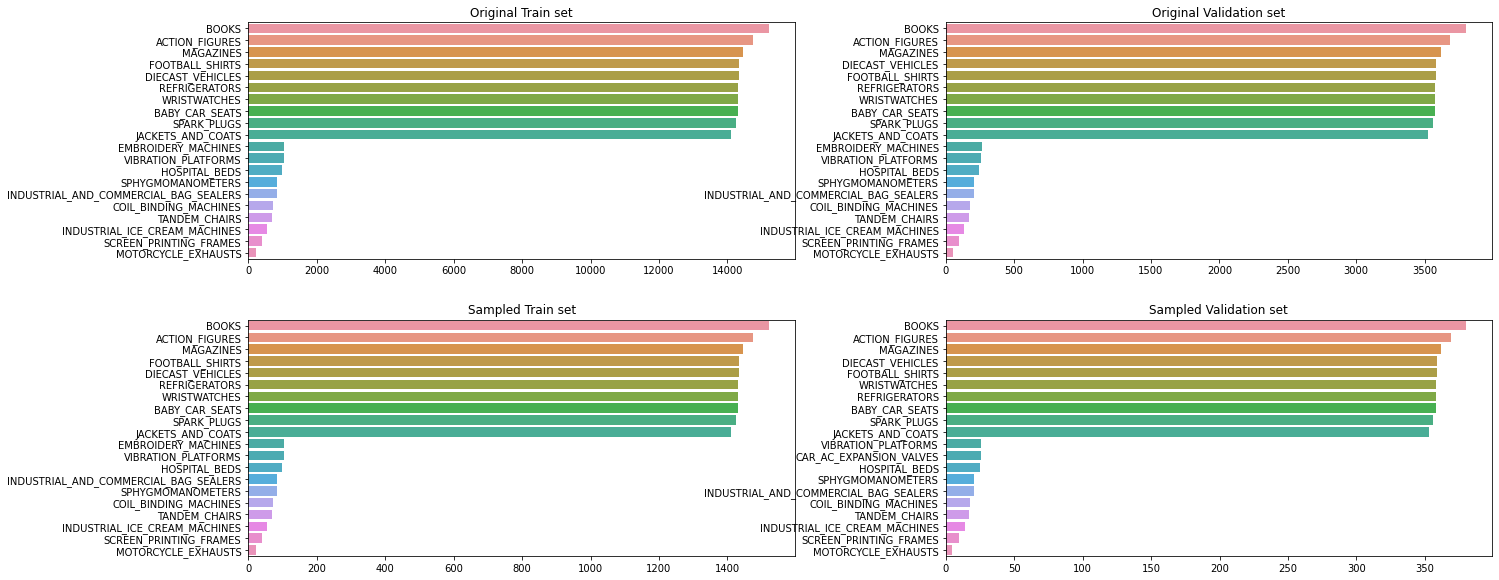

In [4]:
cat_size_train_org = pd.concat([df_train['category'].value_counts()[:10], df_train['category'].value_counts()[-10:]], axis=0)
cat_size_val_org = pd.concat([df_validation['category'].value_counts()[:10], df_validation['category'].value_counts()[-10:]], axis=0)

cat_size_train = pd.concat([data_train['category'].value_counts()[:10], data_train['category'].value_counts()[-10:]], axis=0)
cat_size_val = pd.concat([data_validation['category'].value_counts()[:10], data_validation['category'].value_counts()[-10:]], axis=0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,8), sharey=False)
fig.tight_layout(h_pad=4, w_pad=12)
sns.barplot(y=cat_size_train_org.index, x=cat_size_train_org.values, ax=ax[0,0])
ax[0,0].set_title('Original Train set')
sns.barplot(y=cat_size_val_org.index, x=cat_size_val_org.values, ax=ax[0,1])
ax[0,1].set_title('Original Validation set')
sns.barplot(y=cat_size_train.index, x=cat_size_train.values, ax=ax[1,0])
ax[1,0].set_title('Sampled Train set')
sns.barplot(y=cat_size_val.index, x=cat_size_val.values, ax=ax[1,1])
ax[1,1].set_title('Sampled Validation set')

In [5]:
print(f'Train unique categories: {data_train.category.nunique()}\n\
Validation unique categories: {data_validation.category.nunique()}')

Train unique categories: 632
Validation unique categories: 632


Como puede observarse, las muestras seleccionadas mantienen la distribución de los conjuntos originales; y se asegura que dentro de cada conjunto estén las 632 categorías. Es importante también resaltar que los 2 conjuntos están muy desbalanceados.
Luego, el entrenamiento del modelo seleccionado como definitivo será realizado con todos los datos del conjunto train y se analizará el desempeño sobre todo el conjunto test.

In [6]:
# liberamos memoria
del df
del df_train
del df_validation

# Datasets
Se crearon dos clases dataset, una para levantar todos los datos del lote y otra que lo hace en forma iterable, según las posibilidades de cómputo.

In [8]:
class MeLiChallengeDataset(Dataset):
    def __init__(self, path, transform=None):
#         self.dataset = pd.read_json(path, lines=True)
        self.dataset = path
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()  # Deal with list of items instead of tensor
        
        item = {
            'data': self.dataset.iloc[item]['title'],
            'target': self.dataset.iloc[item]['category']
        }

        if self.transform:
            item = self.transform(item)
        
        return item

In [9]:
class MeLiChallengeiterDataset(IterableDataset):
    def __init__(self, path, transform=None):
        self.dataset_path = path
        self.transform = transform

    def __iter__(self):
        with gzip.open(self.dataset_path, "rt") as fh:
            for l in fh:
                data = json.loads(l)
                item = {
                    "data": data['title'],
                    "target": data['category']
                }
                
                if self.transform:
                    yield self.transform(item)
                else:
                    yield item

# Preprocesamiento
El preprocesamiento de los títulos se realizó utilizando las librerías Gensim y NLTK. Las tareas se ejecutan en el siguiente orden:
- Transformar todas las cadenas en minúsculas
- Eliminar etiquetas de código del tipo <i></i>, <b></b>
- Separar por un espacio de cadenas alfanuméricas
- Reemplazar signos de puntuación ASCII por espacios
- Eliminar cualquier otro caracter que no sea letras o números
- Remover espacios múltiples
- Eliminar dígitos numéricos
- Descartar las cadenas de longitud menor a 3

Una vez generado el diccionario de palabras, se eliminan de este las palabras vacías (o stopwords) del listado predefinido para español en la librería NLTK. Esto es para propiciar que en diccionario aparezcan palabras que puedan aportar información relevante.
Luego, se incluyen dos tokens especiales. Uno para las palabras desconocidas (1) y otro para el relleno al ajustar el tamaño de las cadenas (0).
Por último, se codifican las categorías con un índice, por orden de aparición. En este caso se cuenta con 632 categorías diferentes.

In [10]:
es_stopwords = stopwords.words("spanish")

In [11]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags, #Remove tags using RE_TAGS.
                preprocessing.split_alphanum, #Add spaces between digits & letters using RE_AL_NUM. AGREGADO
                preprocessing.strip_punctuation, #Replace ASCII punctuation characters with spaces using RE_PUNCT.
                preprocessing.strip_non_alphanum, #Remove non-alphabetic characters using RE_NONALPHA.
                preprocessing.strip_multiple_whitespaces, # Remove repeating whitespace characters
                preprocessing.strip_numeric, #Remove digits using RE_NUMERIC.
                preprocessing.strip_short, #Remove words with length lesser than minsize (default = 3).
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )

        # Remove stopwords from dictionary
        stopword_ids = map(self.dictionary.token2id.get, es_stopwords)
        self.dictionary.filter_tokens(bad_ids=stopword_ids)
              
        # Filter the dictionary with extremos words
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
                
        # Make the indices continuous after some words have been removed
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}

    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _remove_stopwords(self, wdlist):
        # incorporamos una funcion para extraer las stopwords en espanol
        return [word for word in wdlist if word not in es_stopwords]
    
    def _sentence_to_indices(self, sentence):
        # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._remove_stopwords(self._preprocess_string(data)))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [12]:
preprocess = RawDataProcessor(data_train_val)

In [13]:
print(f'Tamaño del diccionario: {len(preprocess.dictionary)}')

Tamaño del diccionario: 50002


In [14]:
use_iterableDataset = False

if use_iterableDataset:
    train_dataset = MeLiChallengeiterDataset("./data/meli-challenge-2019/spanish.train.jsonl.gz", transform=preprocess)
    val_dataset = MeLiChallengeiterDataset("./data/meli-challenge-2019/spanish.validation.jsonl.gz", transform=preprocess)
else:
    train_dataset = MeLiChallengeDataset(data_train_val[data_train_val.split == 'train'], transform=preprocess)
    val_dataset = MeLiChallengeDataset(data_train_val[data_train_val.split == 'validation'], transform=preprocess)

# PadSequences
Se creó una clase PadSequences para iguales el tamaño de los datos con los que será alimentada la red.

In [15]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

# DataLoaders
Además, se utilizaron los dataloaders de Pytorch para pasar los datos por lotes a la red.

In [16]:
pad_sequences = PadSequences()
batch_size = 128

if use_iterableDataset:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=pad_sequences, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=pad_sequences, drop_last=False)

# Modelo RNN-LSTM baseline
Se diseñó un modelo simple de red RNN de tipo LSTM (Long Short-Term Memory) con una capa de embeddings y la capa de salida. La función de pérdida utilizada para todo el trabajo fue CrossEntropyLoss, apropiada para problemas de clasificación multiclase. Además, se optó por utilizar Adam como algoritmo de optimización. Por una cuestión de capacidad de procesamiento todos los modelos fueron entrenados en 5 épocas. Se intentó con 10 épocas para poder tener un rango más amplio y evaluar si la función de pérdida podía mostrar signos de sobreajuste; pero esto no fue posible porque en el 90% de los casos el proceso no puede concluir por falta de recursos, se detenía el kernel. La métrica utilizada para evaluar los modelos fue balanced accuracy.

In [28]:
class RNNBaseMeLiChallenge(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 hidden_dim,
                 freeze_embedings=True):
        super().__init__()           
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)     
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
       
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        #LSTM parameters
        self.lstm = nn.LSTM(vector_size, hidden_dim, batch_first=True)
        
        #fully connected layer parameters
        self.linear1 = nn.Linear(hidden_dim, 632)
    
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, (ht, ct) = self.lstm(x)
        out = self.linear1(ht[-1])
        return out

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
EPOCHS = 5
BATCHES_t = (int(train_size/batch_size) + (train_size % batch_size>0))
BATCHES_v = (int(validation_size/batch_size) + (validation_size % batch_size>0))

model = RNNBaseMeLiChallenge(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess.dictionary,
                        vector_size=300,
                        hidden_dim=32,
                        freeze_embedings=True)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in trange(EPOCHS):
    model.to(device)
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, total=BATCHES_t)
    for idx, batch in enumerate(pbar):
        data = batch["data"].to(device)
        target = batch["target"].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_value = loss_function(output, target)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
            pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
            running_loss = 0.0

    model.eval()
    targets = []
    predictions = []
    running_loss = 0
    pbar = tqdm(val_loader, total=BATCHES_v)
    with torch.no_grad():
        for idx, batch in enumerate(pbar):
            data = batch["data"].to(device)
            target = batch["target"].to(device)  
            output = model(data)
            pred = torch.max(output, 1)[1]
            loss_value = loss_function(output, target)
            targets.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
            running_loss += loss_value.item()
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        metric = balanced_accuracy_score(targets, predictions)

    print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.22164891839144502


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.3959469175647462


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.4824150828908482


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5302884803367403


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.5635470682730931


El modelo baseline alcanzó un resultado de 56.4%, y será la línea base para comprar con otras arquitecturas de red e hiperparámetros.

# Modelo RNN-LSTM para ajustar hiperparámetros
Para la búsqueda de los mejores hiperparámetro se agregó una capa lineal oculta adicional y dropout a la red. Además, se definió una función para el entrenamiento y evaluación de los modelos que recibe como parámetros el tamaño de la capa oculta, la proporción para el dropout, la función de activación, el algoritmo de optimización, tasa de aprendizaje, parámetro de regularización, épocas y la opción de guardar los parámetros del modelo entrenado.

In [17]:
class RNNMeLiChallenge(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings,
                 hidden_dim,
                 p_dropout,
                 bdirectional,
                 activation_fn):
        super().__init__()
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        #LSTM parameters
        self.lstm = nn.LSTM(vector_size, hidden_dim, batch_first=True, bidirectional=bdirectional)
        #fully connected layer parameters
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear1_dp = nn.Dropout(p=p_dropout)
        self.output_layer = nn.Linear(hidden_dim, 632)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.activation_fn(self.linear1(ht[-1]))
        if self.training:
            x = self.linear1_dp(x)
        out = self.output_layer(x)
        return out

In [18]:
def train_eval(hidden_dim, bdirectional, p_dropout, activation_fn, opt, lr, wd, epochs, save_model):
    EPOCHS = epochs
    BATCHES_t = (int(train_size/batch_size) + (train_size % batch_size>0))
    BATCHES_v = (int(validation_size/batch_size) + (validation_size % batch_size>0))

    mlflow.set_experiment("exp_nn_rnn_lstm")
    with mlflow.start_run():
        model = RNNMeLiChallenge(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                                 dictionary=preprocess.dictionary,
                                 vector_size=300,
                                 freeze_embedings=True,
                                 hidden_dim=hidden_dim,
                                 bdirectional=bdirectional,
                                 p_dropout=p_dropout,
                                 activation_fn=activation_fn)

        loss_function = nn.CrossEntropyLoss()
        optimizer = opt(model.parameters(), lr=lr, weight_decay=wd)

        mlflow.log_params({
            "model_name": "rnn_lstm",
            "model": model,
            "freeze_embedding": True,
            "vector_size": 300,
            "hidden_dim": hidden_dim,
            "Dropout": p_dropout,
            "LSTM bidirectional": bdirectional,
            "activation_function": activation_fn,
            "optimizer": optimizer,            
            "learning_rate": lr,
            "weight_decay": wd,
        })

        for epoch in trange(EPOCHS):
            model.to(device)
            model.train()
            running_loss = 0.0
            running_loss_flow = []
            pbar = tqdm(train_loader, total=BATCHES_t)
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)
                optimizer.zero_grad()
                output = model(data)
                loss_value = loss_function(output, target)
                loss_value.backward()
                optimizer.step()
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)

            model.eval()
            targets = []
            predictions = []
            running_loss = 0
            running_loss_flow = []
            pbar = tqdm(val_loader, total=BATCHES_v)
            with torch.no_grad():
                for idx, batch in enumerate(pbar):
                    data = batch["data"].to(device)
                    target = batch["target"].to(device)  
                    output = model(data)
                    pred = torch.max(output, 1)[1]
                    loss_value = loss_function(output, target)
                    targets.extend(target.cpu().numpy())
                    predictions.extend(pred.cpu().numpy())
                    running_loss += loss_value.item()
                    running_loss_flow.append(loss_value.item())
                    if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                        pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                        running_loss = 0.0
                mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
                metric = balanced_accuracy_score(targets, predictions)
                mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

            print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')

        ahora = dt.now().strftime('%Y-%m-%d_%H-%M-%S')
        nombre_archivo = 'predictions_' + ahora + '.csv.gz'
        with tempfile.TemporaryDirectory() as tmpdirname:
            targets = []
            predictions = []
            for batch in pbar:
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                pred = torch.max(output, 1)[1]
                targets.extend(target.cpu().numpy())
                predictions.extend(pred.cpu().numpy())
            pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
                f"{tmpdirname}/{nombre_archivo}", index=False
            )
            mlflow.log_artifact(f"{tmpdirname}/{nombre_archivo}")
    
    if save_model:
        # se guarda el modelo entrenado
        path_archivo = './data/RNN_LSTM_TitleClassifier_' + ahora + '.pth'
        torch.save(model.state_dict(), path_archivo)    

## Búsqueda mejor combinación de hiperparámetros
Dada la elección de posibles hiperparámetros que se seleccionó para esta red, hubo que evaluar 36 modelos. Para evitar el riesgo de perder el proceso en algún punto intermedio, se dividió en 3 etapas, es decir de a 12 modelos por vez. Además, todos los modelos fueron entrenados tomando la muestra del 10% de los datos, como se explicó en "Lectura de los datos".
La funcion de activación utilizada en cada etapa fue diferente (relu, mish, tanh), mientras que los parametros hidden_dim, bdirectional, p_dropouts, opts, lrs, wds se iteraron dentro de determinados valores iguales para cada etapa.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
# SET DE PRUEBAS 1
hidden_dim = [64, 128]
bdirectional = [False, True]
p_dropouts = [0, 0.10, 0.20]
activation_fns = [F.relu]
opts = [optim.Adam]
lrs = [0.001]
wds = [0.00001]
n_modelos = len(hidden_dim)*len(bdirectional)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for hdim in hidden_dim:
    for bdir in bdirectional:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 1-{i}')
                            print(hdim, bdir, pdrop, fn, o, l, w)
                            train_eval(hidden_dim=hdim, bdirectional=bdir,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

2022/10/31 19:12:58 INFO mlflow.tracking.fluent: Experiment with name 'exp_nn_rnn_lstm' does not exist. Creating a new experiment.


Modelos a probar: 12
MODELO NRO: 1-1
64 False 0 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.35771805619797886


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5441508198594533


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6202425820524472


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6578269499330396


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6815201188704126
MODELO NRO: 1-2
64 False 0.1 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.31959362501739447


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5324742027002684


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6007714981897603


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6382061368467095


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6665623425169187
MODELO NRO: 1-3
64 False 0.2 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.3157090043167797


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4950638126618338


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5749341802589089


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6079206981592309


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6368678035756435
MODELO NRO: 1-4
64 True 0 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.613900352817796


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7007469934687592


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.730840881706229


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7495873108989772


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7632635662714697
MODELO NRO: 1-5
64 True 0.1 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6069774973645247


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6931495766822152


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.723276911262394


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.743165226094895


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7529741368427387
MODELO NRO: 1-6
64 True 0.2 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.5920387847670802


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6849299444686623


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.714434136032151


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7333416408345497


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7436688959437323
MODELO NRO: 1-7
128 False 0 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4595097297771721


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6261888338760853


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6804925055602956


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7094526127797305


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7340275957642528
MODELO NRO: 1-8
128 False 0.1 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.40995354450922494


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.598530228978575


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6555330718804246


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6944363838073143


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7141842274766669
MODELO NRO: 1-9
128 False 0.2 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4059208707241028


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5914204733455182


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6506534795535909


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.686552723775017


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7103474794033438
MODELO NRO: 1-10
128 True 0 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.693468988643522


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7505102454129198


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.778948691095604


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7849739304102425


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7950081311782543
MODELO NRO: 1-11
128 True 0.1 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6948295675940618


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7525799255362481


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7753842481569535


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7863252871483485


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7927076340107758
MODELO NRO: 1-12
128 True 0.2 <function relu at 0x7f935f8d0af0> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6859057053969851


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7472563450377802


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7678262422166974


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7840682088137364


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7910547722075356


In [19]:
# SET DE PRUEBAS 2
hidden_dim = [64, 128]
bdirectional = [False, True]
p_dropouts = [0, 0.10, 0.20]
activation_fns = [F.mish]
opts = [optim.Adam]
lrs = [0.001]
wds = [0.00001]
n_modelos = len(hidden_dim)*len(bdirectional)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for hdim in hidden_dim:
    for bdir in bdirectional:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 2-{i}')
                            print(hdim, bdir, pdrop, fn, o, l, w)
                            train_eval(hidden_dim=hdim, bdirectional=bdir,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

Modelos a probar: 12
MODELO NRO: 2-1
64 False 0 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.35169565204229786


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5475758598391092


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6192413592510769


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6551859868215101


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6799945406036867
MODELO NRO: 2-2
64 False 0.1 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.33105521809305594


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.5326046873532251


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6017110815910603


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.637312536464007


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6638716885254563
MODELO NRO: 2-3
64 False 0.2 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.27968783532153413


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.48396078709362766


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5628284886893608


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6060666655826125


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6300386095019535
MODELO NRO: 2-4
64 True 0 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6235055043950524


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7049928757510234


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7380932640890968


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7566706532384226


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7643263399065908
MODELO NRO: 2-5
64 True 0.1 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6165308878235934


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6981597253392839


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7308728469775547


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7470284536124916


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7589628548758617
MODELO NRO: 2-6
64 True 0.2 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6010149048581571


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6938731718920172


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7237801468034079


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7374683159491136


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7510318385793404
MODELO NRO: 2-7
128 False 0 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.48404577533010296


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6348529633331902


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6896855360082491


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.719903275406623


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7393832086177852
MODELO NRO: 2-8
128 False 0.1 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4786316973012971


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6233693168406721


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6817605408111422


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.710382518730335


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7330795881699953
MODELO NRO: 2-9
128 False 0.2 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.45175295337426497


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6088180887783085


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6659759494393833


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6964559613928444


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7199647653729919
MODELO NRO: 2-10
128 True 0 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6994426835185666


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7564881643165099


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7824833524230518


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7891930047371847


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.79618243243967
MODELO NRO: 2-11
128 True 0.1 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6983997095647873


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7551871109083225


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7791958012730515


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7905698389299368


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7981425169011623
MODELO NRO: 2-12
128 True 0.2 <function mish at 0x7f0a8ba98670> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6884059908612643


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7508927285817171


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7747604481195509


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7844576563909633


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7918120917590782


In [ ]:
# SET DE PRUEBAS 3
hidden_dim = [64, 128]
bdirectional = [False, True]
p_dropouts = [0, 0.10, 0.20]
activation_fns = [torch.tanh]
opts = [optim.Adam]
lrs = [0.001]
wds = [0.00001]
n_modelos = len(hidden_dim)*len(bdirectional)*len(p_dropouts)*len(activation_fns)*len(opts)*len(lrs)*len(wds)
e = 5
print(f'Modelos a probar: {n_modelos}')
i = 0
for hdim in hidden_dim:
    for bdir in bdirectional:
        for pdrop in p_dropouts:
            for fn in activation_fns:
                for o in opts:
                    for l in lrs:
                        for w in wds:
                            i+=1
                            print(f'MODELO NRO: 3-{i}')
                            print(hdim, bdir, pdrop, fn, o, l, w)
                            train_eval(hidden_dim=hdim, bdirectional=bdir,
                                       p_dropout=pdrop, activation_fn=fn,
                                       opt=o, lr=l, wd=w,
                                       epochs=e, save_model=False)

Modelos a probar: 12
MODELO NRO: 3-1
64 False 0 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.2990410288511766


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4707560444169431


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5505632239152729


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.5971577863472964


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6327944448288356
MODELO NRO: 3-2
64 False 0.1 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.28981522761213346


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.4869915472908025


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5718320286496787


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6202438609699212


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6478244108808965
MODELO NRO: 3-3
64 False 0.2 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.2894775665917219


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.46299011181538907


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.5508941277551009


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.607860344945978


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.6401784812014824
MODELO NRO: 3-4
64 True 0 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6117846013927272


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6981237579685884


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.731276418893219


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7471143966784906


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.759065768918224
MODELO NRO: 3-5
64 True 0.1 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6019410702127933


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6973546667856726


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7295189156836716


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7451460207636497


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7574093143860043
MODELO NRO: 3-6
64 True 0.2 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.5877376635333408


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6853159615483158


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7205735358382889


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.737884208969134


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7504494098379655
MODELO NRO: 3-7
128 False 0 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.4315173839634914


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.598932348291661


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6594894986260962


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6952481934919857


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7241429766057075
MODELO NRO: 3-8
128 False 0.1 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.45017796129550797


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6122014832429189


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.6690071823810223


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7051683142573537


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7244968425142023
MODELO NRO: 3-9
128 False 0.2 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.437702363922181


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.6005289762461089


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.664010618879066


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.6957965570775692


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7218566492126203
MODELO NRO: 3-10
128 True 0 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.7021286163241898


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7575962169695148


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7791021163427418


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7898184569938628


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7967421689971516
MODELO NRO: 3-11
128 True 0.1 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.7006123016818183


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7570024157504707


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7782018176640617


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7899438480526496


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7984358646043751
MODELO NRO: 3-12
128 True 0.2 <built-in method tanh of type object at 0x7f5ec3547a00> <class 'torch.optim.adam.Adam'> 0.001 1e-05


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.688924053963812


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7496623652999767


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.775568951911084


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7873594285782356


  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.79299423698453


A continuación se puede ver la tabla de registros de MLflow con los primeros resultados, ordenados por la métrica.
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/mlflow_rnn.png?raw=true" alt="registros mlflows rnn"/>
Como resultado de las 36 pruebas, se obtuvieron modelos con métricas en el rango de 63.0% a 79.8%. En general, se puede apreciar que el rango de métricas de las pruebas es superior a los resultados de las pruebas de parámetros del modelo de red MLP realizada en el trabajo anterior (36.0% a 67.7%), mostrando una considerable mejora con redes recurrentes. Además, es claro que en las primeras 18 posiciones se ubican las redes con LSTM bidireccional, resultando en un parámetro clave para mejorar el desempeño del modelo.

# Entrenamiento del modelo con la mejor combinación de hiperparámetros
El modelo seleccionado como definitivo es el que puede verse seleccionado en la imagen anterior. Su elección se debió a que era el mejor modelo en término de overfitting. Si bien no se ubica entre los primeros lugares, la diferencia en la métrica no era significativa respecto a los primeros, que mostraron overfitting incluso antes de la 3ra época. Para ejemplificar esto, se muestra en la siguiente imagen las curvas de función de pérdida para los primeros 3 modelos de la tabla.
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/loss_sobreajuste_rnn.png?raw=true" alt="loss sobreajuste rnn"/>
En cambio, las curvas de pérdida para el modelo seleccionado muestran una mejor situación:
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/loss_mejor_modelo_rnn.png?raw=true" alt="curvas mejor modelo rnn"/>
La métrica obtenida en el entrenamiento y evaluación con la muestra de datos fue 75.9%. Los parámetros del modelo seleccionado son:
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/param_mejor_modelo_rnn.png?raw=true" alt="param mejor modelo rnn"/>

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
train_eval(hidden_dim=64, bdirectional=True,
           p_dropout=0.10, activation_fn=F.mish,
           opt=optim.Adam, lr=0.001, wd=0.00001,
           epochs=5, save_model=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.7917360542978968


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.8066810837778166


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.8133874300117693


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.8188051951209082


  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.8207354245761599


Luego, se realizó el entrenamiento y evaluación de este modelo pero con el total de los datos de train y validation. Así, la precisión balanceada ascendió a 82.1%. Este experimento también fue monitoreado con MLflow para que sea incluido en los registros. Se guardaron los parámetros entrenados del modelo para utilizarlos en el siguiente paso y evaluar el desempeño sobre el conjunto de prueba.
Se incluye la gráfica de la función de pérdida para el modelo definitivo entrenado, donde se evidencia más claramente que no existe sobreajuste en el rango de épocas de entrenamiento.
<img src="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/images/loss_modelo_rnn_entrenado.png?raw=true" alt="loss modelo rnn entrenado"/>

# Predicciones sobre el set TEST
El conjunto test fue sometido al mismo preprocesamiento utilizado en las etapadas anteriores, teniendo en consideración que el diccionario es el formado a partir de los conjuntos de entrenamiento y evaluación porque el conjunto de prueba son datos "nuevos" que se presentan al modelo.

In [22]:
model = RNNMeLiChallenge(pretrained_embeddings_path='./data/SBW-vectors-300-min5.txt.bz2',
                         dictionary=preprocess.dictionary,
                         vector_size=300,
                         freeze_embedings=True,
                         hidden_dim=64,
                         bdirectional=True,
                         p_dropout=0.10,
                         activation_fn=F.mish)

In [23]:
model.load_state_dict(torch.load('./data/RNN_LSTM_TitleClassifier_2022-11-02_13-49-23.pth'))

<All keys matched successfully>

## Levantar datos de test

In [24]:
df_test = pd.read_json(f"./data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)
test_size = len(df_test)
batch_size = 128
pad_sequences = PadSequences()
test_dataset = MeLiChallengeDataset(df_test, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_sequences, drop_last=False)

## Predicciones

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
BATCHES_test = (int(test_size/batch_size) + (test_size % batch_size>0))
model.to(device)
model.eval()
targets = []
predictions = []
pbar = tqdm(test_loader, total=BATCHES_test)

with torch.no_grad():
    for idx, batch in enumerate(pbar):
        data = batch["data"].to(device)
        target = batch["target"].to(device)  
        output = model(data)
        pred = torch.max(output, 1)[1]
        targets.extend(target.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

    metric = balanced_accuracy_score(targets, predictions)

print(f'Balanced accuracy TEST set: {metric}')

  0%|          | 0/498 [00:00<?, ?it/s]

Balanced accuracy TEST set: 0.8932230911093763


Finalmente, la métrica lograda a partir de las predicciones sobre el conjunto de prueba (89.3%) fue mejor que la obtenida con el modelo MLP (79.1%) y sumado a esto, el método RNN es bueno para el procesamiento de secuencias, por lo que se concluye que estas redes neuronales son ideales para este tipo de problemas.

# Archivos de respaldo
<a href="https://github.com/RodrigoHRuiz/Diplo2022_Grupo16/blob/main/DeepLearning/02%20Modelo%20RNN-LSTM/TP%20-%20Deep%20Learning%20-%20RNN-LSTM.ipynb" target="_blank">Notebook de todo el proceso del modelo RNN-LSTM</a>
<br>
<a href="https://drive.google.com/file/d/1-m8hQhn89ac_MCwIyvfQC01RSOMbLeoo/view?usp=share_link" target="_blank">Experimentos MLflow con modelo RNN-LSTM</a>
<br>
<a href="https://drive.google.com/file/d/1XvWke8FH49BFJxkWE3LXulUhWonTT6-a/view?usp=share_link" target="_blank">Parámetros entrenados del mejor modelo RNN-LSTM</a>